In [1]:
%matplotlib inline
import copy
from qutip import *
import numpy as np
import math, cmath
import matplotlib.pyplot as plt
from tqdm import tqdm

import utilities as use
from stateobj import QState, QAncilla

from IPython.display import Markdown, display

In [2]:
UNITARY_EVOLUTION = False  # Slower
MEQ_EVOLUTION = True
SIM_ID = '60D'  # string (system dimentions)
PLOT = True

TIMESTEPS = 10000
TIMEDELTA = 1e-02 
OMEGA = 10  # Strength of Interaction

## System

In [3]:
# SYSTEM
system_dimentions = 60
system_energy = 1
system = use.create_system('fock', n_dims=system_dimentions, n=0)
system.energy = system_energy
# Stampa informazioni sul Sistema
display(system)

Quantum object: dims = [[60], [60]], shape = (60, 60), type = oper, isherm = True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

## Ancilla

In [4]:
alpha = complex(1/math.sqrt(2), 0)
beta = complex(1/math.sqrt(2), 0)
phi = np.pi/3
eta = QAncilla(alpha, beta, phi)
# Stampa informazioni sull'Ancella
display(eta)
stable_temperature = - system.energy / math.log(eta.factor)
display(Markdown(
    f"This will thermalize the System to $T = {stable_temperature}$")
)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.5  +0.j         0.   +0.j         0.   +0.j        ]
 [0.   +0.j         0.25 +0.j         0.125+0.21650635j]
 [0.   +0.j         0.125-0.21650635j 0.25 +0.j        ]]

This will thermalize the System to $T = -3.476059496782208$

### Interaction
$$
  \hat{V}_n = \hbar\Omega[A_+B_+ + A_-B_-], \\
  A_+ = \hat{a}^\dagger, \\
  A_- = \hat{a}, \\
  B_+ = \hat{\sigma}_1^- + \hat{\sigma}_2^- \equiv \begin{pmatrix} 0&0&0\\1&0&0\\1&0&0 \end{pmatrix}, \\
  B_- = \hat{\sigma}_1^+ + \hat{\sigma}_2^+ \equiv \begin{pmatrix} 0&1&1\\0&0&0\\0&0&0 \end{pmatrix} .
$$

In [5]:
# System Opeators
ap_int = tensor(system.ap, qeye(3))
am_int = tensor(system.am, qeye(3))
# Ancilla Operators 
bp_int = tensor(qeye(system_dimentions), eta.sigmaminus)
bm_int = tensor(qeye(system_dimentions), eta.sigmaplus)
# INTERACTION
V = OMEGA * ( ap_int*bp_int + am_int*bm_int )

## Unitary Evolution

In [6]:
rho = copy.deepcopy(system)

In [7]:
if UNITARY_EVOLUTION:
    """Fa evolvere il sistema tramite [timesteps] collisioni con l'Ancilla
    nello stato eta.
    Calcola il tempo di termalizzazione e il tempo per raggiungere una
    temperatura stabile. 
    Salva il vettore di Temperature calcolate a ogni step e lo stato del
    Sistema"""    
    for t in tqdm(range(TIMESTEPS)):
        rho = rho.interact(eta, V, TIMEDELTA)
    
    temperatures = np.array([rho.get_temperature() for rho in rho.history])
    first_stable = np.where(np.isclose(temperatures, temperatures[-1], rtol=1e-04))[0][0]
    
    print(f"Temperature becomes stable at step {first_stable}:\n"
          f"First stable Temperature: {temperatures[first_stable]};\n"
          f"Last stable Temperature: {temperatures[-1]}.")
    rho.check_time(first_stable)
    
    if SIM_ID is not None:
        qsave(rho, f'objects/steadystate_unitary_{SIM_ID}')
        np.save(f'objects/system_temperatures_unitary_{SIM_ID}', temperatures)
else:
    try:
        """Carica i file delle Temperature e lo stato del Sistema"""
        rho = qload(f'objects/steadystate_unitary_{SIM_ID}')
        rho = QState(rho, energy=system_energy)
        temperatures = np.load(f'objects/system_temperatures_unitary_{SIM_ID}.npy')
        PLOT = True
    except FileNotFoundError as e:
        print('Error!\n', str(e))
        PLOT = False

Error!
 [Errno 2] No such file or directory: 'objects/steadystate_unitary_60D.qu'


In [8]:
rho.energy

1

In [9]:
if UNITARY_EVOLUTION or PLOT:
    plt.plot(temperatures)
    plt.title("Phaseonium Temperature in time (by Unitary Evolution)")
    plt.ylim(0, stable_temperature+0.25*stable_temperature)
    plt.axhline(temperatures[-1], ls='--', color='r', label=f'Stable Temperature: {temperatures[-1]:.4}')
    plt.legend()
    plt.show()

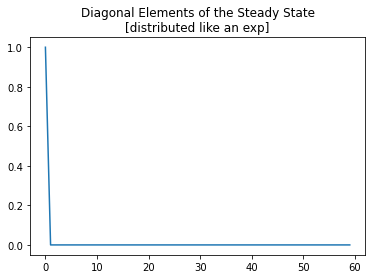

Negative Temperature from Boltzmann-like distribution:
nan


/tmp/ipykernel_19913/735186426.py:4: RuntimeWarning: invalid value encountered in double_scalars
  temperature = -rho.energy / math.log(rho.diag()[-2]/rho.diag()[-1])


In [10]:
plt.plot(rho.diag())
plt.title("Diagonal Elements of the Steady State\n[distributed like an exp]")
plt.show()
temperature = -rho.energy / math.log(rho.diag()[-2]/rho.diag()[-1])
print(f"Negative Temperature from Boltzmann-like distribution:\n{temperature}")

## Evolution by Master Equation

$$\begin{split}
    \frac{\Delta\rho}{\Delta t} = (\hbar\Omega)^2\Delta t \big( 
        \langle B_+B_- \rangle (A_-\rho A_+ -\frac{1}{2}[A_+A_-; \rho]) \\
        + \langle B_-B_+ \rangle (A_+\rho A_- -\frac{1}{2}[A_-A_+; \rho])
    \big)
\end{split}$$

In [11]:
rho = copy.deepcopy(system)

In [12]:
if MEQ_EVOLUTION:
    """Fa evolvere il sistema tramite [TIMESTEPS] collisioni con l'Ancilla
    nello stato eta.
    Usa la Master Equation.
    Calcola il tempo di termalizzazione e il tempo per raggiungere una
    temperatura stabile. 
    Salva il vettore di Temperature calcolate a ogni step e lo stato del
    Sistema"""

    for t in tqdm(range(TIMESTEPS)):
        rho = rho.meq_step(eta, OMEGA, TIMEDELTA)
    
    temperatures = np.array([rho.get_temperature() for rho in rho.history])
    
    first_stable = np.where(np.isclose(temperatures, temperatures[-1], rtol=1e-04))[0][0]
    print(f"Temperature becomes stable at step {first_stable}:\n"
          f"First stable Temperature: {temperatures[first_stable]};\n"
          f"Last stable Temperature: {temperatures[-1]}.")
    rho.check_time(first_stable)
    
    if SIM_ID is not None:
        qsave(rho, f'objects/steadystate_meq_{SIM_ID}')
        np.save(f'objects/system_temperatures_meq_{SIM_ID}', temperatures)
else:
    try:
        """Carica i file delle Temperature e lo stato del Sistema"""
        rho = qload(f'objects/steadystate_meq_{SIM_ID}')
        temperatures = np.load(f'objects/system_temperatures_meq_{SIM_ID}.npy')
        PLOT = True
    except FileNotFoundError as e:
        print('Error!\n', str(e))
        PLOT = False

100%|████████████████████████████████████| 10000/10000 [00:31<00:00, 322.50it/s]
/home/fedesss/PROGRAMMAZIONE/QUANTUM/stateobj.py:44: RuntimeWarning: divide by zero encountered in log
  return - self._energy / np.log(self.diag()[1].real / self.diag()[0].real)


Temperature becomes stable at step 8088:
First stable Temperature: -3.5897147551690005;
Last stable Temperature: -3.5895462846895176.


### System State at time 8088

Quantum object: dims = [[60], [60]], shape = (60, 60), type = oper, isherm = True
Qobj data =
[[1.10336691e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.45781684e-08 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.93038628e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.40625002e-01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.87500002e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.50000003e-01]]

*System Temperature undefined*

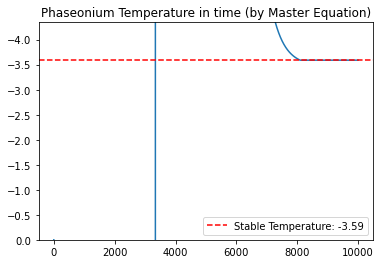

In [13]:
if MEQ_EVOLUTION or PLOT:
    plt.plot(temperatures)
    plt.title("Phaseonium Temperature in time (by Master Equation)")
    plt.ylim(0, stable_temperature+0.25*stable_temperature)
    plt.axhline(temperatures[-1], ls='--', color='r', label=f'Stable Temperature: {temperatures[-1]:.4}')
    plt.legend()
    plt.show()

### "Negative" Temperature
Diagonal elements are distributed like $e^{mx+q}$:
$$
    \exp\{mx+q\} = \exp\{q\} \exp\{mx\} \equiv \frac{1}{Z}\exp\left\{x\frac{\hbar\omega}{KT}\right\}
$$

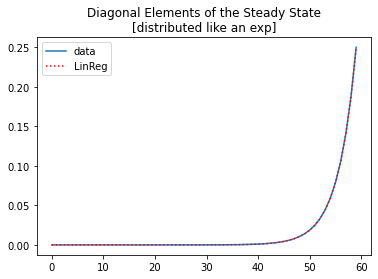

Negative Temperature from Boltzmann-like distribution:
3.476059497628948


In [23]:
# Diagonal elements of rho are distributed like an exp
plt.plot(rho.diag(), label="data")
# Regression of exp
m = (np.log(rho.diag())[-1]-np.log(rho.diag())[-2])
q = np.log(rho.diag())[0]-0.04
plt.plot(np.exp(m*np.arange(0, 60)+q), 'r:', label="LinReg")
# Settings
plt.title("Diagonal Elements of the Steady State\n[distributed like an exp]")
plt.legend()
plt.show()
temperature = -rho.energy / math.log(rho.diag()[-2]/rho.diag()[-1])
print(f"Negative Temperature from Boltzmann-like distribution:\n{temperature}")

## Steady State

$$
\rho^* = \frac{1}{Z}
\begin{pmatrix}
    1 &  &  &  \\
    & \exp\left( \frac{\hbar\omega}{KT} \right) & & \\
    & & \exp\left( 2\frac{\hbar\omega}{KT} \right) & \\
    & & & \ddots \\
    & & & & \exp\left( n\frac{\hbar\omega}{KT} \right) \\
    & & & & & \ddots
\end{pmatrix}
= \frac{1}{Z}
\begin{pmatrix}
    E^0 &  &  &  \\
    & E^1 & & \\
    & & E^2 & \\
    & & & \ddots \\
    & & & & E^n \\
    & & & & & \ddots
\end{pmatrix}
$$

In [27]:
q = math.log(rho.diag()[0])
1/math.exp(q)

90689378.36736041

In [16]:
rho.partition

90689378.36736034

In [17]:
m = math.log(rho.diag()[-1])-math.log(rho.diag()[-2])
round(math.exp(m),5) == round(eta.factor,5)

True